## IPVisibility RPM

In [1]:
from IPEnvironmentShapeRobot import CollisionCheckerShapeRobot
from IPEnvironmentShapeRobot import ShapeRobot, ShapeRobotWithOrientation
from shapely.geometry import Point, Polygon, LineString
from shapely.affinity import scale, translate
import matplotlib.pyplot as plt

import numpy as np



# Definition of a testing environment
obs1 = LineString([(5,18),(5,8),(20,8),(20,18)]).buffer(1.0)
obs2 = LineString([(15,15), (15,25), (30,25), (30,10)]).buffer(1.0)

# obs2 = scale(obs1, yfact=-1, origin='center')
# obs2 = translate(obs2, xoff=10, yoff=7)
trapField = dict()
trapField["obs1"] = obs1
trapField["obs2"] = obs2

# define robot geometry
robot_shape = Polygon([
    (-0.5, -0.5),  # unten links
    (3, -0.5),     # unten rechts
    (3, 0.0),      # Innenknick rechts
    (0.5, 0.0),    # Innenknick unten horizontal
    (0.5, 1.0),    # oben links vom L-Schenkel
    (-0.5, 1.0)    # oben links außen
])
shape_robot = ShapeRobotWithOrientation(robot_shape, limits=[[0.0, 22.0,], [0.0, 22.0], [-np.pi, np.pi]])

environment = CollisionCheckerShapeRobot(trapField, shape_robot)

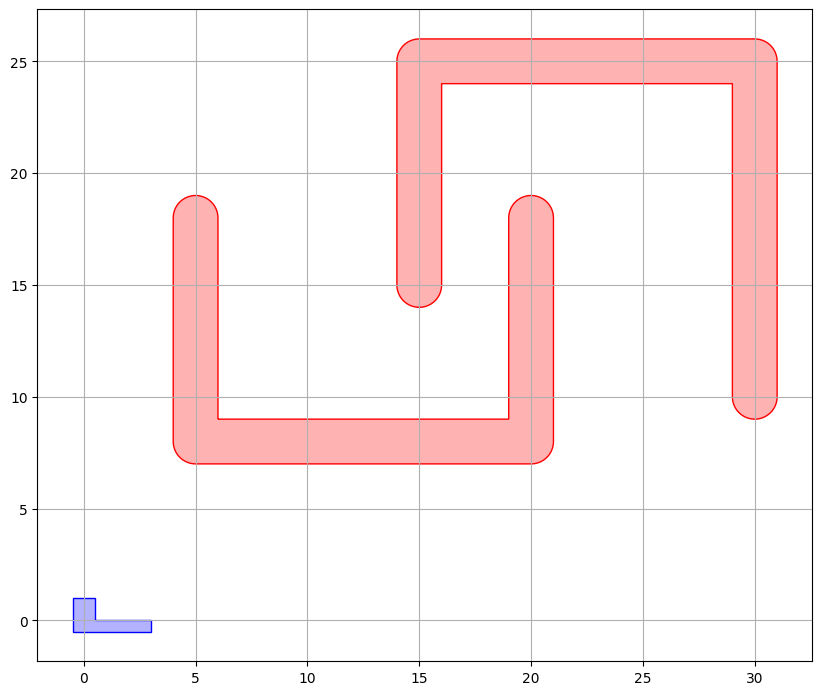

In [2]:
# define robot geometry

fig_local = plt.figure(figsize=(10,10))
ax = fig_local.add_subplot(1,1,1)
environment.drawObstacles(ax)

In [3]:
from IPVisibilityPRM import VisPRM 

visPRM = VisPRM(environment)
visConfig = dict()
visConfig["radius"] = 10
visConfig["ntry"] = 50

start = [[25,5,0]]
goal  = [[15,12,0]]

solution = visPRM.planPath(start, goal, visConfig)

if len(solution) == 0:
    print("No solution found")

solution

['start', 58, 7, 9, 2, 114, 16, 35, 10, 153, 'goal']

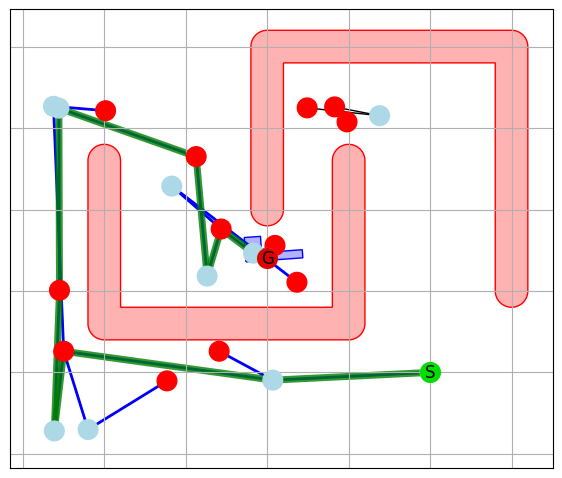

In [4]:
from IPVISVisibilityPRM import visibilityPRMVisualize
fig_local = plt.figure(figsize=(7,7))
ax = fig_local.add_subplot(1,1,1)
visibilityPRMVisualize(visPRM,solution,ax=ax)

In [5]:
import copy
def interpolate_line(startPos, endPos, step_l):
    steps = []
    line = np.array(endPos) - np.array(startPos)
    line_l = np.linalg.norm(line)
    step = line / line_l * step_l
    n_steps = np.floor(line_l / step_l).astype(np.int32)
    c_step = np.array(startPos, dtype=np.float32)
    for i in range(n_steps):
        steps.append(copy.deepcopy(c_step))
        c_step += step
    if not (c_step == np.array(endPos)).all():
        steps.append(np.array(endPos))
    return steps


In [6]:
# from IPVISVisibilityPRM import visibilityPRMVisualizeWspace
# import matplotlib.animation
# matplotlib.rcParams['animation.embed_limit'] = 256
# from IPython.display import HTML, display

# planner=visPRM

# fig_local = plt.figure(figsize=(7, 7))
# ax = fig_local.add_subplot(1, 1, 1)
# ## get positions for solution
# solution_pos = [planner.graph.nodes[node]['pos'] for node in solution]
# ## interpolate to obtain a smoother movement
# i_solution_pos = [solution_pos[0]]
# for i in range(1, len(solution_pos)):
#     segment_s = solution_pos[i-1]
#     segment_e = solution_pos[i]
#     i_solution_pos = i_solution_pos + interpolate_line(segment_s, segment_e, 0.5)[1:]
# ## animate
# frames = len(i_solution_pos)

# r = environment.robot
# workSpaceLimits = environment.robot.getLimits()

# def animate(t):
#     ## clear taks space figure
#     ax.cla()
#     ## fix figure size
#     ax.set_xlim(workSpaceLimits[0])
#     ax.set_ylim(workSpaceLimits[1])
#     ## draw obstacles
#     #environment.drawObstacles(ax)
#     ## update robot position
#     pos = i_solution_pos[t]
#     r.setTo(pos)
#     visibilityPRMVisualizeWspace(visPRM,solution,ax=ax)
    

# ani = matplotlib.animation.FuncAnimation(fig_local, animate, frames=frames)
# html = HTML(ani.to_jshtml())
# display(html)
# plt.close()



## Smooth the path

### Generate random points on edges

In [7]:
import networkx as nx
from PathSmoother import random_pt_on_edge


knot_positions = nx.get_node_attributes(visPRM.graph,'pos')
random_edge_pts = []

for i in range(len(solution) - 1):
    u = solution[i]
    v = solution[i+1]
    
    random_edge_pts.append(random_pt_on_edge(knot_positions[u], knot_positions[v]))

random_edge_pts

[(18.049099173894177, 4.659388377728424, -1.357900466292307),
 (10.591275499297613, 5.1834270971858825, -2.3164064647010183),
 (2.0045936841446057, 1.9978279446785225, 0.6336766743651427),
 (2.021116328661307, 3.7522913524230095, 1.050807010126304),
 (2.23755758692693, 14.231791968459175, 2.467395754413504),
 (2.5947725297604105, 21.08735182943417, 1.3770338375528874),
 (11.063522477584819, 13.644167316091695, 0.27253549888617146),
 (11.88952080610394, 12.846240745389405, -0.5237152399484053),
 (13.124808964588217, 13.093770821334349, -0.24592807795401317),
 (14.214653275087667, 12.298609019365642, 0.06654703543720819)]

### Check for obstacles between those points 

In [8]:
from PathSmoother import findRandomShortcut, insertAndConnectPointsOnEdges


print("Solution before: ", solution)
id_counter = 0
color = "#e28a0e"

u, v = findRandomShortcut(visPRM, random_edge_pts)
print("u: ", u, " v: ", v)
insertAndConnectPointsOnEdges(visPRM.graph, solution, random_edge_pts, u, v, id_counter, color)
print("Solution after: ", solution)


Solution before:  ['start', 58, 7, 9, 2, 114, 16, 35, 10, 153, 'goal']
u:  6  v:  7
Solution after:  ['start', 58, 7, 9, 2, 114, 16, 'S1', 'S2', 10, 153, 'goal']


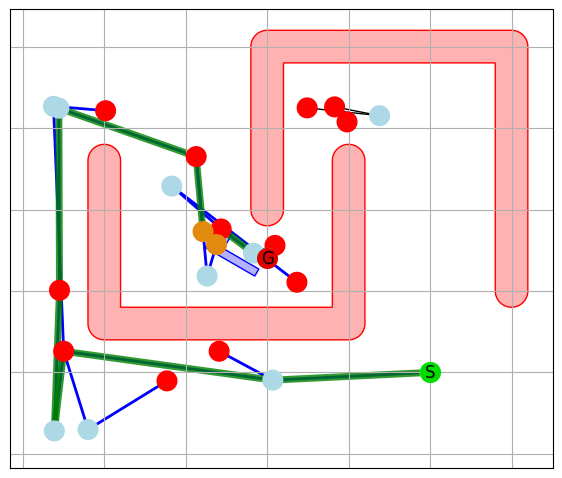

In [9]:
from IPVISVisibilityPRM import visibilityPRMVisualize
opt_fig_local = plt.figure(figsize=(7,7))
ax = opt_fig_local.add_subplot(1,1,1)
visibilityPRMVisualize(visPRM, solution, ax=ax)

# print(list(visPRM.graph.edges("S1")))
# print(list(visPRM.graph.edges("S2")))
# print(visPRM.graph.nodes[23]["pos"])